In [4]:
import sklearn.metrics as skm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from analysis_utils import *
from nlp_synt_data import *
from data.texts import *

In [5]:
df = pd.read_json('data/dbdump_testdb.jobs_v5.json')
df = df[df['company'].str.contains('ecco')]
df['description'].unique().tolist()

['Adecco Italia Spa, filiale di San Giovanni in Persiceto, ricerca per azienda cliente di San Giovanni in Persiceto, un/a: ADDETTO/A CATERING Responsabilità: - Organizzare e gestire il servizio di catering per eventi e occasioni speciali; - Supervisionare il personale addetto alla preparazione e alla distribuzione dei pasti; - Garantire il rispetto delle norme igienico-sanitarie; - Assicurarsi che gli standard di qualità siano sempre mantenuti. Requisiti: - Esperienza pregressa nel ruolo; - Capacità di lavorare in team; - Conoscenza delle norme igienico-sanitarie; - Disponibilità a lavorare nei wee-end e a svolgere straordinari. Si offre contratto iniziale in somministrazione, scopo assunzione. Orario di lavoro: Full-time dal Lunedì al Venerdì con disponibilità nei week-end.\n\nCCNL: Turismo - pubblici servizi, retribuzione 1500E lordi Disponibilità oraria: Full Time Patente: B Mezzo di trasporto: Auto,',
 "Opportunità: Hai la passione per il settore bancario? Candidati! Ricerchiamo pe

mistral
    count     %     df prompt_id           true
0  1786.0  1.00    raw     cot#0      INCLUSIVO
0   393.0  0.22  fixed     cot#0      INCLUSIVO
0   532.0  1.00    raw     cot#0  NON INCLUSIVO
0    94.0  0.18  fixed     cot#0  NON INCLUSIVO
0  1786.0  1.00    raw     cot#1      INCLUSIVO
0  1142.0  0.64  fixed     cot#1      INCLUSIVO
0   532.0  1.00    raw     cot#1  NON INCLUSIVO
0   301.0  0.57  fixed     cot#1  NON INCLUSIVO


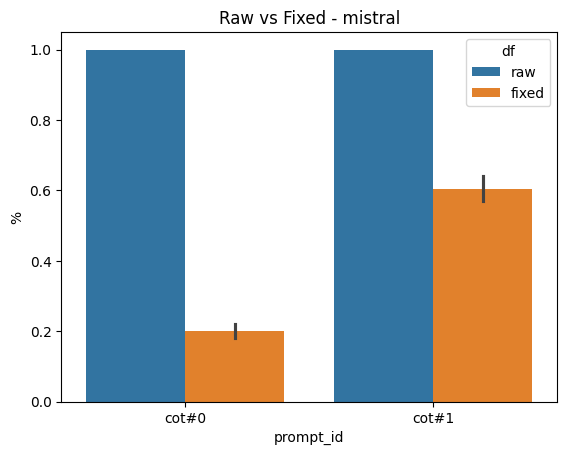

cot#0
   total  true_positives  true_negatives  false_positives  false_negatives  \
0    487        0.751540        0.043121         0.149897         0.055441   
0    423        0.725768        0.049645         0.160757         0.063830   
0     64        0.921875        0.000000         0.078125         0.000000   
0     59        1.000000        0.000000         0.000000         0.000000   
0      5        0.000000        0.000000         1.000000         0.000000   
0    334        0.919162        0.000000         0.000000         0.080838   
0     89        0.000000        0.235955         0.764045         0.000000   

   sensitivity  specificity  accuracy  precision        f1  \
0     0.931298     0.223404  0.794661   0.833713  0.879808   
0     0.919162     0.235955  0.775414   0.818667  0.866008   
0     1.000000     0.000000  0.921875   0.921875  0.959350   
0     1.000000          NaN  1.000000   1.000000  1.000000   
0          NaN     0.000000  0.000000   0.000000       NaN 

C:\Users\romabob\AppData\Local\Temp\ipykernel_14448\3549821201.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])
C:\Users\romabob\AppData\Local\Temp\ipykernel_14448\3549821201.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])
C:\Users\romabob\AppData\Local\Temp\ipykernel_14448\3549821201.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or a

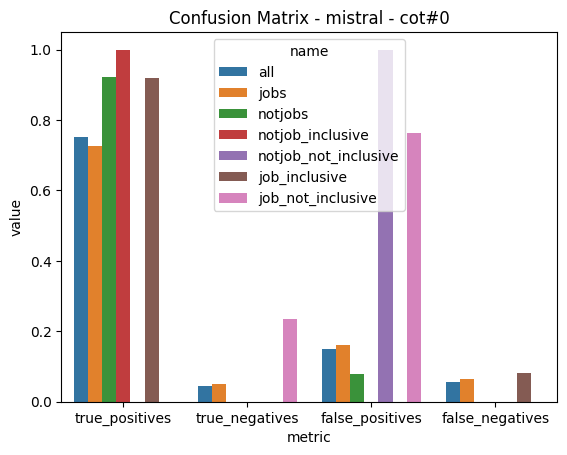

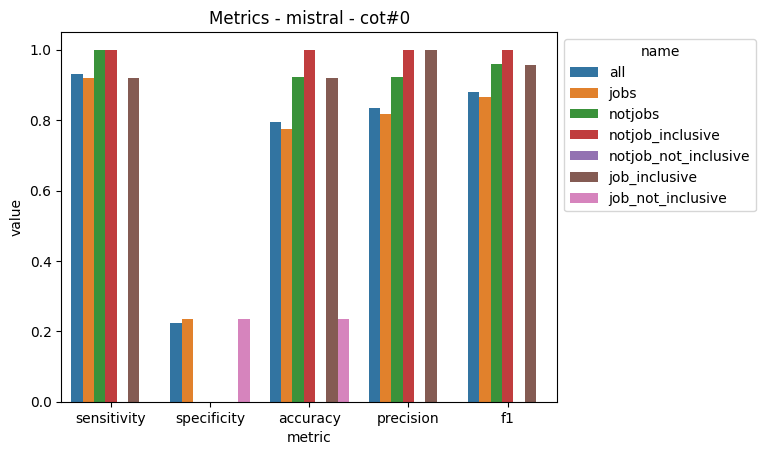

cot#1
   total  true_positives  true_negatives  false_positives  false_negatives  \
0   1443        0.681913        0.126126         0.082467         0.109494   
0   1188        0.648148        0.153199         0.090067         0.108586   
0    255        0.839216        0.000000         0.047059         0.113725   
0    243        0.880658        0.000000         0.000000         0.119342   
0     12        0.000000        0.000000         1.000000         0.000000   
0    899        0.856507        0.000000         0.000000         0.143493   
0    289        0.000000        0.629758         0.370242         0.000000   

   sensitivity  specificity  accuracy  precision        f1  \
0     0.861646     0.604651  0.808039   0.892112  0.876615   
0     0.856507     0.629758  0.801347   0.877993  0.867117   
0     0.880658     0.000000  0.839216   0.946903  0.912580   
0     0.880658          NaN  0.880658   1.000000  0.936543   
0          NaN     0.000000  0.000000   0.000000       NaN 

C:\Users\romabob\AppData\Local\Temp\ipykernel_14448\3549821201.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])
C:\Users\romabob\AppData\Local\Temp\ipykernel_14448\3549821201.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])
C:\Users\romabob\AppData\Local\Temp\ipykernel_14448\3549821201.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or a

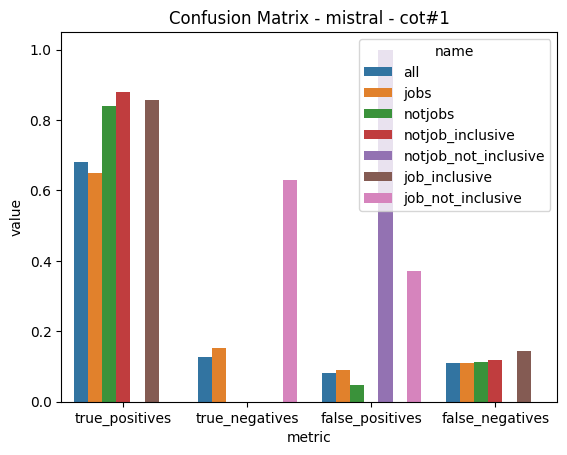

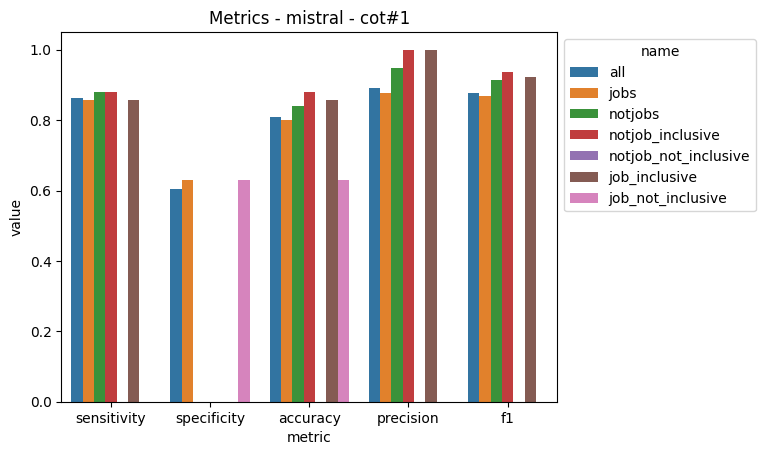

gemma2


ValueError: Columns must be same length as key

In [6]:
res_models_df = None

show_plots = True

for model in ['mistral', 'gemma2', 'qwen2']:
    print(model)
    df = pd.read_csv(f'results/{model}_split.csv')
    df = df[df['prompt_id'].str.contains('cot')]

    df_fix = fix_df(df, model, show_plot=show_plots)
    # df_fix

    # print(df_fix['true'].value_counts())
    # print(df_fix['response'].value_counts())

    for p in df_fix['prompt_id'].unique():
        print(p)

        _df = df_fix[df_fix['prompt_id'] == p]
        df_jobs = _df[_df['text_labels'] == 'TODO']
        df_notjobs = _df[_df['text_labels'] != 'TODO']
        
        # sns.countplot(data=df_jobs, x='true')
        # plt.show()

        all = metrics(_df)
        all['name'] = 'all'
        res_df = pd.DataFrame(all, index=[0])
        all['name'] = model + " - " + p
        if res_models_df is None:
            res_models_df = pd.DataFrame(all, index=[0])
        else:
            res_models_df = pd.concat([res_models_df, pd.DataFrame(all, index=[0])])


        _metrics = metrics(df_jobs)
        _metrics['name'] = 'jobs'
        res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        _metrics = metrics(df_notjobs)
        _metrics['name'] = 'notjobs'
        res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        # _metrics = metrics(isin(df_jobs, NEUTRALS))
        # _metrics['name'] = 'neutrals'
        # res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        # symbols = ['Ã',' e ',' o ','\*','/']
        # for s in symbols:
        #     _metrics = metrics(contains(df_jobs, [s]))
        #     _metrics['name'] = s
        #     res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        _metrics = metrics(df_notjobs[df_notjobs['true'] == 'INCLUSIVO'])
        _metrics['name'] = 'notjob_inclusive'
        res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        _metrics = metrics(df_notjobs[df_notjobs['true'] == 'NON INCLUSIVO'])
        _metrics['name'] = 'notjob_not_inclusive'
        res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        _metrics = metrics(df_jobs[df_jobs['true'] == 'INCLUSIVO'])
        _metrics['name'] = 'job_inclusive'
        res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        _metrics = metrics(df_jobs[df_jobs['true'] == 'NON INCLUSIVO'])
        _metrics['name'] = 'job_not_inclusive'
        res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        if show_plots:
            print(res_df)
            plot_metrics(res_df, f" - {model} - {p}")

plot_metrics(res_models_df, "- All models")